## 1) Loading the dataset

Setting up the appropriate directory and loading the dataset from Microsoft One-Drive

Features include :

Temperature (AT), 

Ambient Pressure (AP), 

Relative Humidity (RH) and 

Exhaust Vacuum (V)

***Importing the file from One Drive***

In [1]:
import os
import requests
import pandas as pd

link = "https://powergrid1989-my.sharepoint.com/:x:/g/personal/60003871_powergrid_in/EX93H3icKghJpKJB1YEWIU8BHp-xTKGZcpDSoa051phQMQ?e=7Q1kwG&download=1"

output_file_o = "PowerPlant.csv"

# Send an HTTP GET request to the OneDrive link to download the file
response = requests.get(link)

# Save the file content to a temporary file in runtime
if response.status_code == 200:
    # Save the content to a local CSV file
    with open(output_file_o, "wb") as f:
        f.write(response.content)
else:
    print('Failed to download the file. Status code:', response.status_code)


# Checking if the file exists
if os.path.exists(output_file_o):
    # Checking the file size in bytes
    file_size = os.path.getsize(output_file_o)

    # Defining a minimum acceptable file size of 200kB
    min_file_size = 200000

    if file_size > min_file_size:
        print("\nFile downloaded successfully.")
    else:
        print(f"File size is too small ({file_size} bytes). Download may have been unsuccessful.")
else:
    print("File does not exist. Download may have been unsuccessful.")





File downloaded successfully.


In [2]:
os.getcwd()

'/Users/macbook/Library/CloudStorage/OneDrive-PowerGridCorporationofIndiaLimited/CC/3_ML-AI Course/3_Study/Course-3_MachineLearning-1/MachineLearning-I/Assignment_Linear Regression'

### **Reading the CSV File in Pandas DF**

In [3]:
file = "PowerPlant.csv"
pp_df = None

pp_df = pd.read_csv(file, na_values=[''])

if pp_df is not None:
    # Data was successfully read from one of the files
    print(" File Loaded Successfully in pp_df : ")
    display(pp_df.head())

else:
    # Both files were not found
    print("No data found in either file.")

 File Loaded Successfully in pp_df : 


,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


## 2) Exploratory Data Analysis

**Verifing isloaded data in dataframe**

---

 Getting the number of rows and columns

In [4]:
num_rows, num_columns = pp_df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 9568
Number of columns: 5


In [5]:
pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [6]:
pp_df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [7]:
# Checking percentage of missing values in each column
missing_percentage = (pp_df.isnull().mean() * 100).round(2)

# Checking for duplicate rows
duplicate_rows = pp_df.duplicated().sum()

# Calculating the percentage of duplicate rows
duplicate_percentage = (duplicate_rows / len(pp_df) * 100).round(2)

print("Percentage of Missing Values in Each Column of the Power Plant Data:")
print(missing_percentage)

print("\nPercentage of Duplicate Rows in the DataFrame: {0} %".format(duplicate_percentage))


Percentage of Missing Values in Each Column of the Power Plant Data:
AT    0.0
V     0.0
AP    0.0
RH    0.0
PE    0.0
dtype: float64

Percentage of Duplicate Rows in the DataFrame: 0.43 %


**---> It seems that the data contains no missing values and no significant duplicate rows**

<Axes: >

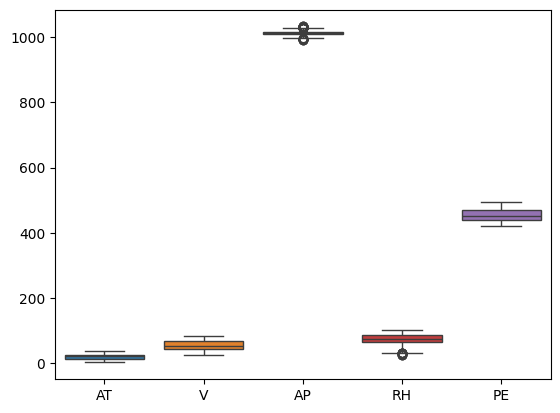

In [8]:
import seaborn as sns

sns.boxplot(data = pp_df)

---> **It seems the data needs to be scaled properly before building Linear Model and there are no significant outliers present in the data**

### **Checking Multicolinearity among the features**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

pp_df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


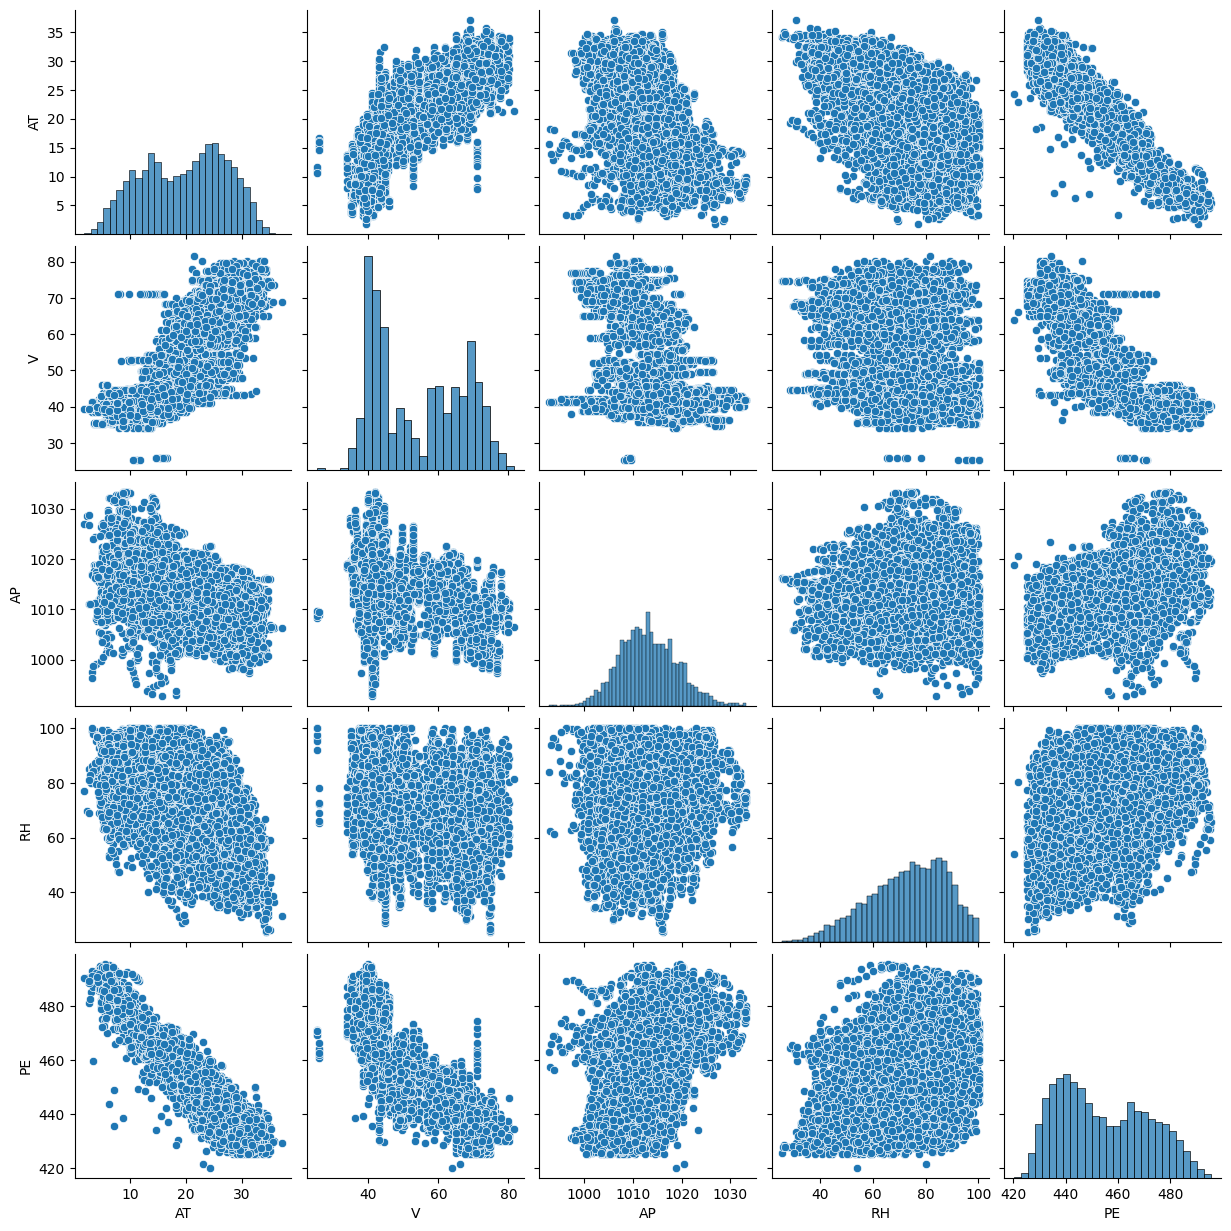

In [120]:
sns.pairplot(pp_df)

<Axes: >

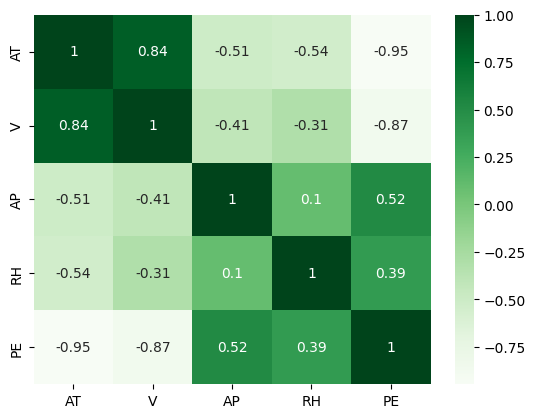

In [10]:
sns.heatmap(data = pp_df.corr(), cmap= "Greens", annot=True)

---> **It seems the features 'AT' & 'V' are highly correlated so we can remove V, and lets also check VIF.**

In [11]:
# Split DF into train/test data frames
train, test = train_test_split(pp_df, train_size=0.7, test_size=0.3, random_state=100)

In [12]:
# Defining columns for X & y sets
X_cols = train.columns.drop('PE')
y_cols = ['PE']

X_train = train[X_cols]
y_train = train[y_cols]

X_test = test[X_cols]
y_test = test[y_cols]

In [13]:
# Performing Scaling using MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_vif = pd.DataFrame(X_train_scaled, columns=X_train.columns)
vif = pd.DataFrame()
vif['Features'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)

print('\n VIF Values : \n', vif)


 VIF Values : 
   Features    VIF
1        V  23.80
0       AT  22.45
3       RH   8.03
2       AP   7.98


---> **Since, the feature 'V' has the highest VIF and has high correlation with 'AT' , therefore we can remove feature 'V'.**

## 3) Building Linear Regression Model

Lets first build the model with all the features and then rebuild the model with feature 'V' removed for comparision

In [14]:
# Part-1: Perform Linear Regression using OLS in Statsmodel

# Constant column needs to be added for LR using Statsmodel
X_train_scaled_const = sm.add_constant(X_train_scaled)

# Building Linear Model-1 
lm_OLS = sm.OLS(y_train, X_train_scaled_const).fit()
print(lm_OLS.summary()) 

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.201e+04
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:12:38   Log-Likelihood:                -19647.
No. Observations:                6697   AIC:                         3.930e+04
Df Residuals:                    6692   BIC:                         3.934e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        502.6367      0.522    962.218      0.0

In [15]:
# Building LR model after dropping the feature 'V' having high VIF

X_cols_updated = X_cols.drop('V')

# Updated X_train and X_test
X_train_updated = train[X_cols_updated]
X_test_updated = test[X_cols_updated]


In [16]:
# Scaling the updated X_train
X_train_up_scaled = scaler.fit_transform(X_train_updated)

# Checking VIF for X_train
X_vif = pd.DataFrame(X_train_up_scaled, columns=X_train_updated.columns)
vif = pd.DataFrame()
vif['Features'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = True)

print('\n VIF Values : \n', vif)


 VIF Values : 
   Features   VIF
0       AT  3.43
2       RH  7.49
1       AP  7.92


In [17]:
# VIF values have been subsequently reduced after removing 'V' but VIF values greater than 5 also needs to keep under check.
# Hence, Dropping the feature 'AP' and 'V' having highest VIF

X_cols_updated = X_cols_updated.drop('AP')

# Updated X_train and X_test
X_train_updated = train[X_cols_updated]
X_test_updated = test[X_cols_updated]

In [18]:
# Scaling the updated X_train
X_train_up_scaled = scaler.fit_transform(X_train_updated)

# Checking VIF for X_train
X_vif = pd.DataFrame(X_train_up_scaled, columns=X_train_updated.columns)
vif = pd.DataFrame()
vif['Features'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = True)

print('\n VIF Values : \n', vif)


 VIF Values : 
   Features   VIF
0       AT  3.06
1       RH  3.06


In [19]:
# Performing Linear Regression using OLS after dropping 'V' and 'AP'

# Adding a Constant column for LR using Statsmodel
X_train_up_scaled_const = sm.add_constant(X_train_up_scaled)

# Building a new Model for updated X_train, Model-2

lm2_OLS = sm.OLS(y_train, X_train_up_scaled_const).fit()
print("\nThe summary results for Model-2 are as below :\n")
print(lm2_OLS.summary())


The summary results for Model-2 are as below :

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 3.932e+04
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:12:56   Log-Likelihood:                -19998.
No. Observations:                6697   AIC:                         4.000e+04
Df Residuals:                    6694   BIC:                         4.002e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

---> **We can see in the Model-2 developed after removing 'V' and 'AP', AIC BIC scores including the F-statistic have been significantly improved. Hence, we take this model for prediction.**

## 4) Making Predictions and Residual Analysis

In [20]:
# Predicting the values using Model-2

y_train_pred = lm2_OLS.predict(X_train_up_scaled_const)

X_test_up_scaled = scaler.transform(X_test_updated)
X_test_up_scaled_const = sm.add_constant(X_test_up_scaled)

y_test_pred = lm2_OLS.predict(X_test_up_scaled_const)


In [21]:
# Residual Analysis for the Model-2

res_train = y_train - y_train_pred.reshape(-1,1)
res_test = y_test - y_test_pred.reshape(-1,1)

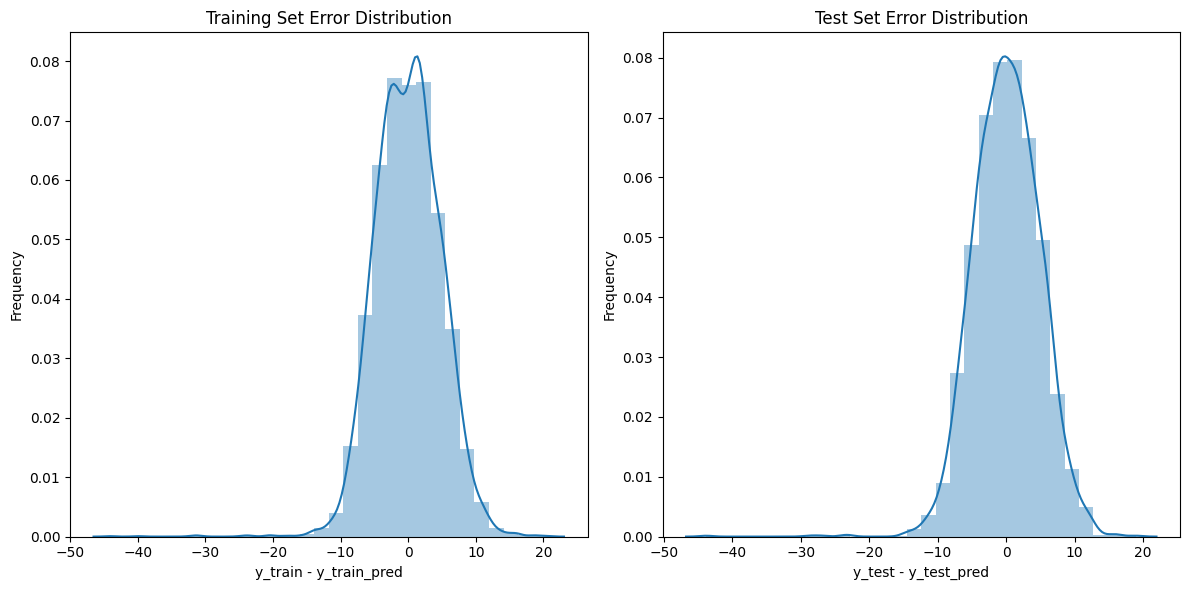

In [22]:
# Creating subplots for error term distributions of training and test sets
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Creating a 1x2 grid of subplots

# Subplot for training set error terms
sns.distplot(res_train, bins=30, ax=axes[0])  
axes[0].set_title('Training Set Error Distribution')  
axes[0].set_xlabel('y_train - y_train_pred')  
axes[0].set_ylabel('Frequency')  

# Subplot for test set error terms
sns.distplot(res_test, bins=30, ax=axes[1])  
axes[1].set_title('Test Set Error Distribution')  
axes[1].set_xlabel('y_test - y_test_pred')  
axes[1].set_ylabel('Frequency')  

plt.tight_layout()  # Ensuring tight layout to prevent overlap
plt.show()


---> **It seems the residuals are following the normal distribution with a mean '0'.**

In [23]:
# Evaluating the model using R^2 values

r2_test = sklearn.metrics.r2_score(y_test_pred, y_test)
r2_train = sklearn.metrics.r2_score(y_train_pred, y_train)

print("\nUpon Model Evaluation, following are the R-squared scores for Model-2.\n")
print("R-sq for Train set : ", round(r2_train,5))
print("R-sq for Test set : ", round(r2_test,5))



Upon Model Evaluation, following are the R-squared scores for Model-2.

R-sq for Train set :  0.91487
R-sq for Test set :  0.91276


## 5) Checking Optimum Train/Test-Split-Size

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assuming only the features AT and RH
X_cols = ['AT', 'RH']
y_cols = ['PE']

X = pp_df[X_cols]
y = pp_df[y_cols]

# Defining a range of train sizes to consider
train_sizes = np.linspace(0.1, 0.9, 9) 

# Initialize lists to store results
train_scores = []
test_scores = []

scaler = MinMaxScaler()

# Loop over different train sizes
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=100)

    # Scaling data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit a model - Linear Regression fom SKLearn
    lm = LinearRegression()
    lm.fit(X_train_scaled, y_train)

    # Evaluate model performance
    train_r2 = r2_score(y_train, lm.predict(X_train_scaled))
    test_r2 = r2_score(y_test, lm.predict(X_test_scaled))

    train_scores.append(train_r2)
    test_scores.append(test_r2)

# Store results in a DataFrame
results_df = pd.DataFrame({
    'Train_Size': train_sizes,
    'Train_R2': train_scores,
    'Test_R2': test_scores
})

print(results_df)


   Train_Size  Train_R2   Test_R2
0         0.1  0.917348  0.921220
1         0.2  0.919494  0.921170
2         0.3  0.917369  0.922394
3         0.4  0.918611  0.922399
4         0.5  0.920628  0.921219
5         0.6  0.921210  0.920515
6         0.7  0.921546  0.919492
7         0.8  0.922471  0.914558
8         0.9  0.922214  0.909510


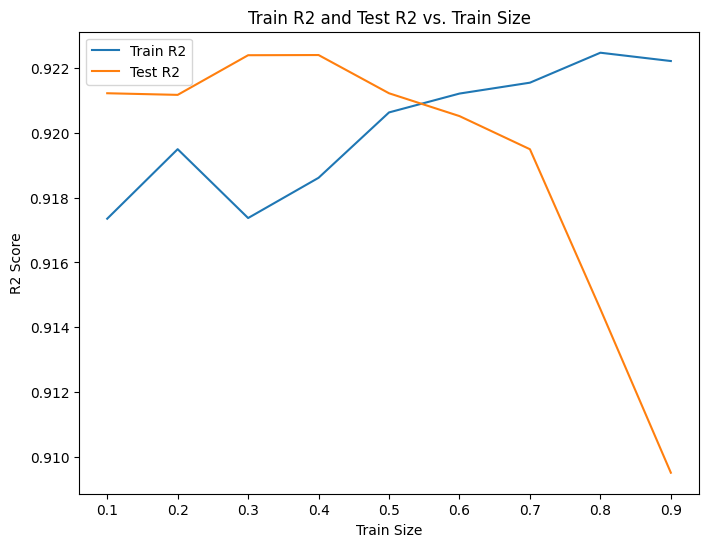

In [25]:
# Plotting Train R2 and Test R2 against Train Size
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='Train_Size', y='Train_R2', label='Train R2')
sns.lineplot(data=results_df, x='Train_Size', y='Test_R2', label='Test R2')
plt.xlabel('Train Size')
plt.ylabel('R2 Score')
plt.title('Train R2 and Test R2 vs. Train Size')
plt.legend()
plt.show()

Optimum Train Size would be nearly 0.55 since, R-sq values for Train and Test Data are nearly equal. But if we are considering train size as 0.7, the model also performs well with Train_R-sq value of 0.92155 and Test_R-sq Value of 0.91949.

## 6) Building the Final Model

In [26]:
# Training the Final Model

# Assuming only the features AT and RH
X_cols = ['AT', 'RH']
y_cols = ['PE']

X = pp_df[X_cols]
y = pp_df[y_cols]

scaler = MinMaxScaler()


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

# Since it is evident from the box plots, if we are considering the features 'AT' and 'RH' 
# Scaling has also not been required

# Fit a model - Linear Regression fom SKLearn
lm_best = LinearRegression()
lm_best.fit(X_train, y_train)

# Predict on X_test & X_train
y_train_pred = lm_best.predict(X_train)
y_test_pred = lm_best.predict(X_test)

r2_test_best = sklearn.metrics.r2_score(y_test, y_test_pred)
r2_train_best = sklearn.metrics.r2_score(y_train, y_train_pred)

print("\nUpon Model Evaluation, following are the R-squared scores for Final Model.\n")
print("R-sq for Train set : ", round(r2_train_best,5))
print("R-sq for Test set : ", round(r2_test_best,5))

print("\nCoefficient for Intercept: ", lm_best.intercept_[0])
print("Coefficient for Feature '{0}' is : {1}".format(X_cols[0],lm_best.coef_[0][0]))
print("Coefficient for Feature '{0}' is : {1}".format(X_cols[1],lm_best.coef_[0][1]))



Upon Model Evaluation, following are the R-squared scores for Final Model.

R-sq for Train set :  0.92155
R-sq for Test set :  0.91949

Coefficient for Intercept:  516.2764918897751
Coefficient for Feature 'AT' is : -2.3901708302179347
Coefficient for Feature 'RH' is : -0.20432761439411687


### Hence, the Final Model becomes :

## $PE = 516.276 - 2.39 * AT - 0.204 * RH$

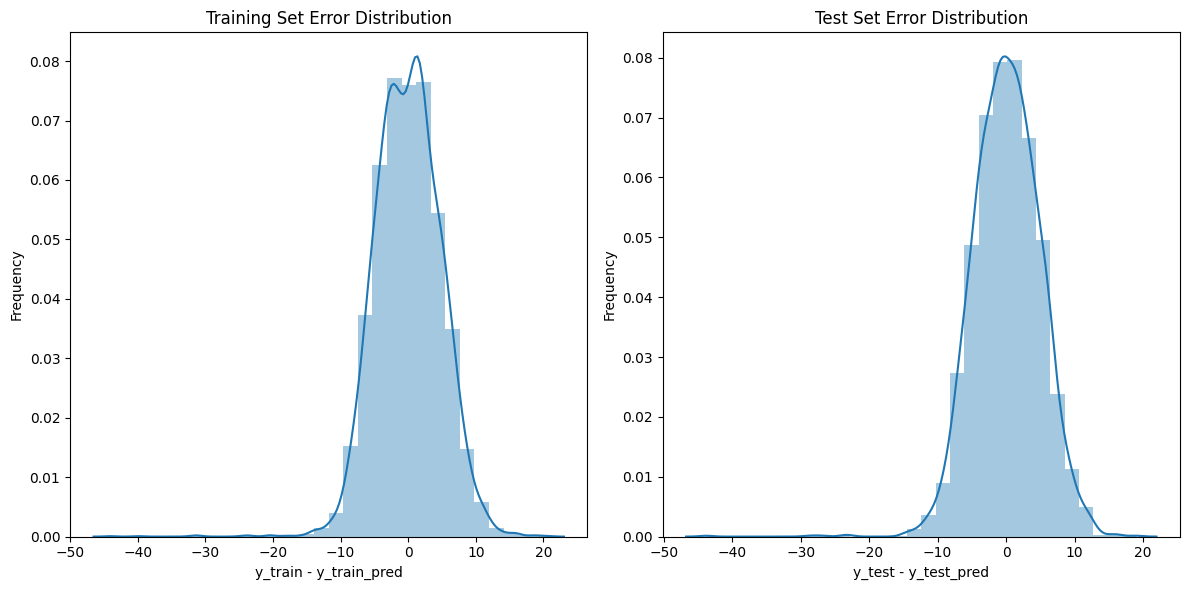

In [27]:
# Residual Analysis for the Final Model

res_train = y_train - y_train_pred.reshape(-1,1)
res_test = y_test - y_test_pred.reshape(-1,1)

# Creating subplots for error term distributions of training and test sets
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Creating a 1x2 grid of subplots

# Subplot for training set error terms
sns.distplot(res_train, bins=30, ax=axes[0])  
axes[0].set_title('Training Set Error Distribution')  
axes[0].set_xlabel('y_train - y_train_pred')  
axes[0].set_ylabel('Frequency')  

# Subplot for test set error terms
sns.distplot(res_test, bins=30, ax=axes[1])  
axes[1].set_title('Test Set Error Distribution')  
axes[1].set_xlabel('y_test - y_test_pred')  
axes[1].set_ylabel('Frequency')  

plt.tight_layout()  # Ensuring tight layout to prevent overlap
plt.show()


--> Residuals are normally distributed along Origin

<Axes: >

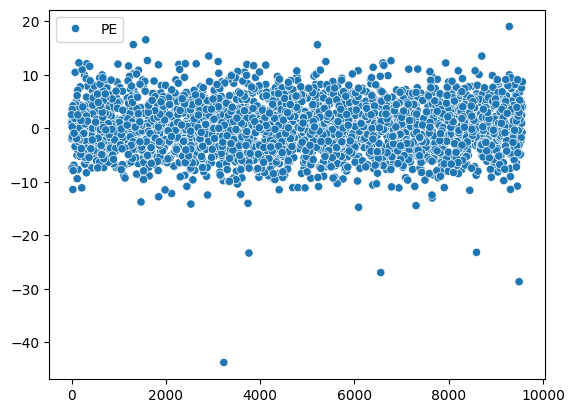

In [28]:
# Check for Hetroskadasticity

sns.scatterplot(res_test)